<a href="https://colab.research.google.com/github/muscak/Facial-Emotion-Recognition/blob/master/Facial_Emotion_Recognition_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Detection

# Problem Definition
Recent research suggests that a significant portion, approximately 55%, of emotional communication primarily relies on facial expressions and other visual cues [1]. Hence, developing a model that precisely recognizes facial emotions represents a major advancement in equipping AI-powered machines with emotional intelligence. Automated facial expression recognition systems offer vast potential across diverse applications, spanning from understanding human behavior and identifying mental health conditions to improving virtual assistants for customer-centric businesses. It’s also important for Emotion Recognition for Human-Robot Interaction [2]. Using Deep Learning and AI techniques to create a computer vision mode that can accurately detect facial emotion is an important step towards the development of emotionally intelligent machines powered by AI. CNN has been extensively used in diverse computer vision applications, including FER. At the beginning of the 21st century, several studies in the Facial Expression Recognition (FER) literature found that the CNN is robust to face location changes and scale variations and behaves better than the multilayer perceptron (MLP) in the case of previously unseen face pose variations [3].

The objective of this project involves leveraging Deep Learning and Artificial Intelligence methodologies to develop a computer vision model. This model aims to precisely identify emotions in facial expressions by performing multi-class classification on images of faces, effectively associating each expression with its corresponding emotion.

# Dataset
We have 20,214 images consisting of three different image sets which are train, validation and test sets. Each set contains four different emotions (classes) that are happy, neutral, sad and surprised.

|||
|-|-|
|**happy**|: Images of people who have happy facial expressions.|
|**sad**|: Images of people with sad or upset facial expressions.|
|**surprise**|: Images of people who have shocked or surprised facial expressions.|
|**neutral**|: Images of people showing no prominent emotion in their facial expression at all.|

You may see some of the example images for each emotion from the training set in Visualizing our Classes section. Exact number of images for each set and for each emotion can be seen in Checking Distribution of Classes section.

# Mounting Google Drive

Since Deep learning requires a lot of computational power to run on [4], we build our entire experiment on Google Colab which provides GPUs both for free with some limitations and paid GPU runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to the folders
root_path = '/content/drive/MyDrive/Colab Notebooks/Applied Data Science/Capstone Project/Facial Emotion Recognition/'
data_path = root_path + 'Data/Facial_emotion_images.zip'
model_path = root_path + 'Models'

# Import Libraries

In [ ]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Misc. Libraries
import zipfile
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Importing Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

# Import different type of layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D

# Import optimizer
from tensorflow.keras.optimizers import Adam, AdamW

# To optimize the training process
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Import keras utilities
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

# Importing libraries for evaluating the model
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# Load Data

## Unzip the Images

In [ ]:
with zipfile.ZipFile(data_path, 'r') as images:
  images.extractall()

In [ ]:
emotions = ['happy', 'neutral', 'sad', 'surprise']
num_classes = len(emotions)

In [ ]:
images_path = 'Facial_emotion_images'

In [ ]:
# Printing a random image from the training set to have further information about the images
seed = 101
np.random.seed(seed)
random_index = np.random.randint(0, len(os.listdir(images_path + '/train/' +
                                                     'happy')))
print(random_index)

img = img_to_array(load_img(images_path + '/train/' + 'happy' + '/' +
                   os.listdir(images_path + '/train/' + 'happy')[random_index]
                                     ))
print(img.shape)

863
(48, 48, 3)


🔎 **Observations:** Above mentioned random image from the training set has 48 x 48 size and 3 channels which shows that the images have 3 colors (RGB).

In [ ]:
# Create an image size tuple
img_size = (img.shape[0], img.shape[0])

## Visualize Classes

We'll visualize 9 random images from each class (emotion) in training set.

In [ ]:
def visualize_classes(emotion):
  '''
    This function visualizes the random 9 images of the given emotion in the
    training set in a 8x8 canvas.

    ---
    ## Parameters:
    - emotion <string>: Facial emotion. It also the name of the folder in the
      training dataset.
  '''
  np.random.seed(seed) # Set the seed to have the same result in every runtime
  plt.figure(figsize=(8,8))
  for i in range(1, 10, 1):
    random_index = np.random.randint(0, len(os.listdir(images_path + '/train/' +
                                                     emotion)))
    plt.subplot(3, 3, i)
    img = load_img(images_path + '/train/' + emotion + '/' +
                   os.listdir(images_path + '/train/' + emotion)[random_index],
                   target_size = img_size)
    plt.imshow(img)
    plt.grid(False)

  plt.suptitle('Emotion: ' + emotion.capitalize(), fontsize=16)
  plt.tight_layout()
  plt.show()

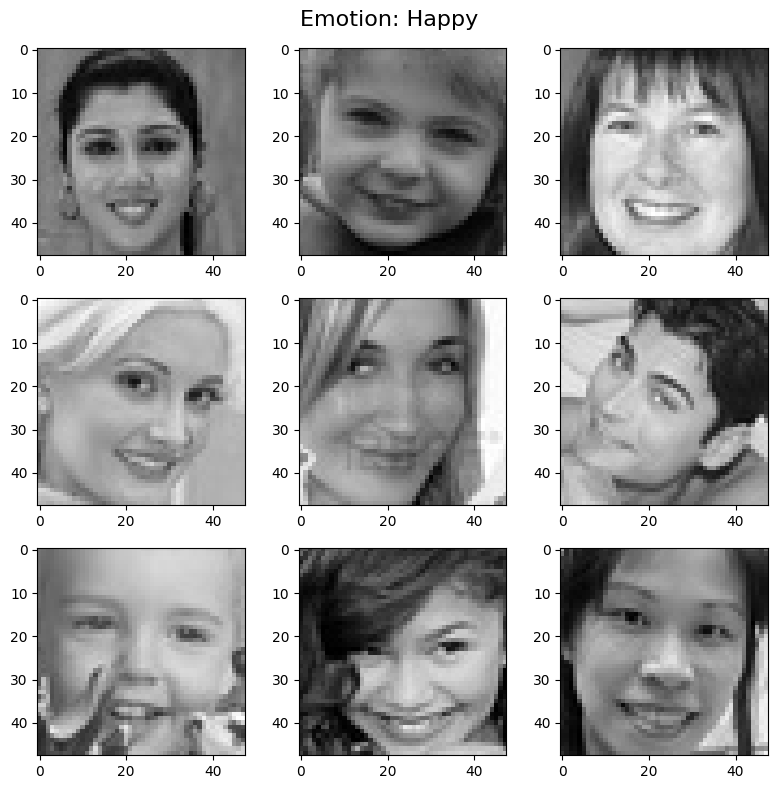

In [ ]:
visualize_classes(emotions[0])

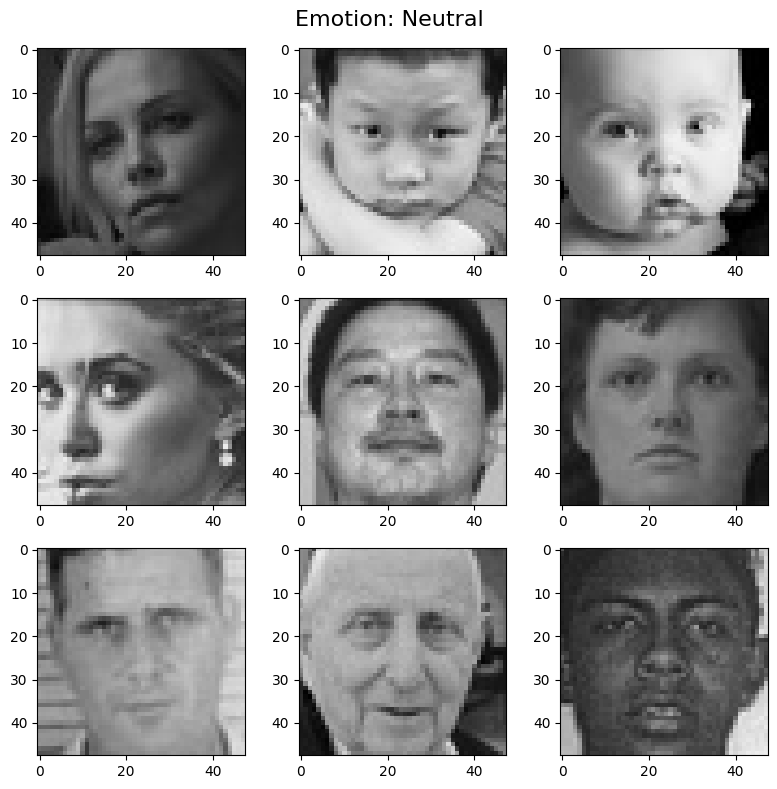

In [ ]:
visualize_classes(emotions[1])

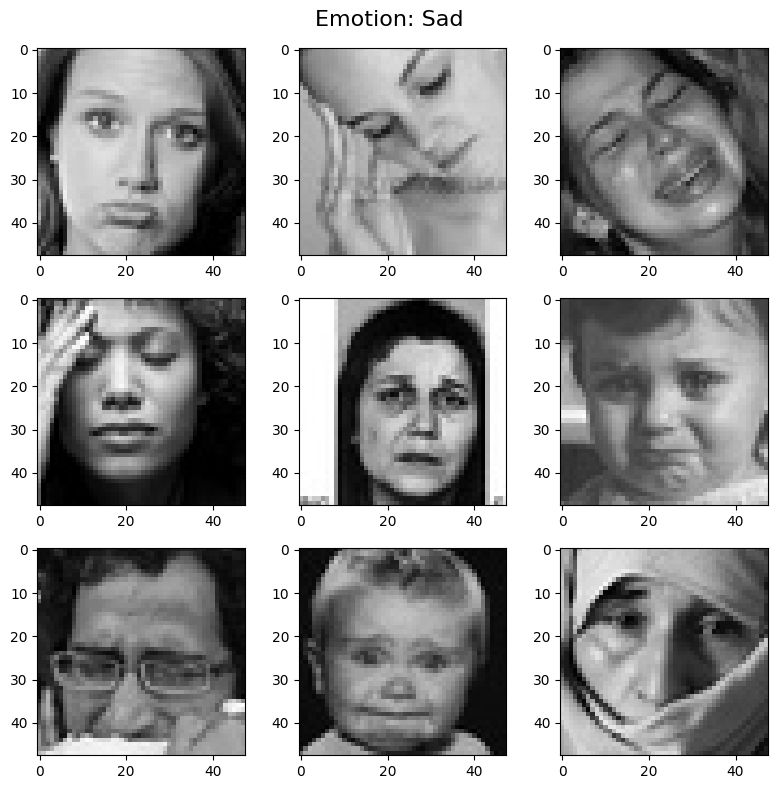

In [ ]:
visualize_classes(emotions[2])

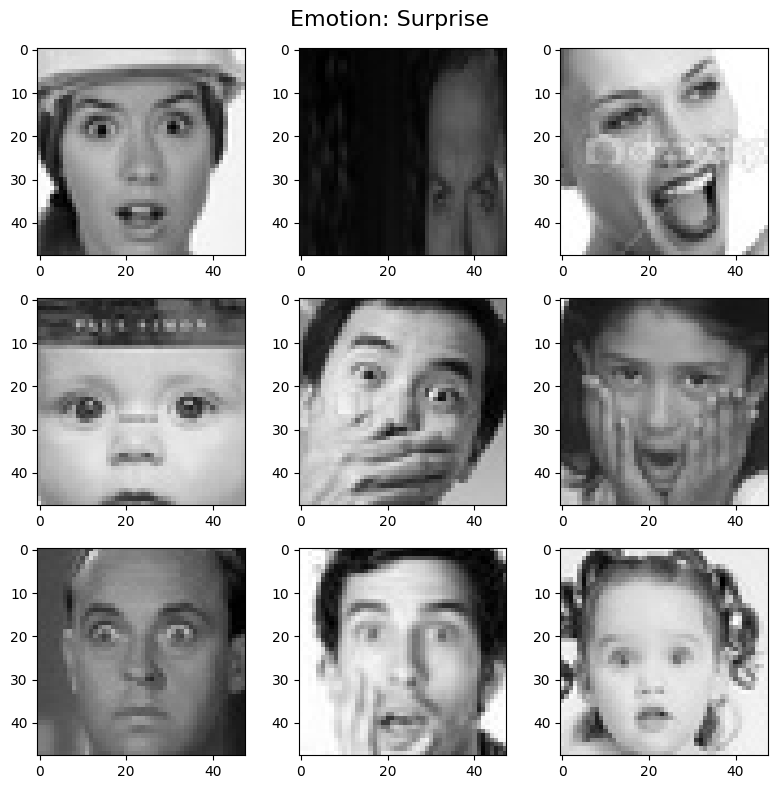

In [ ]:
visualize_classes(emotions[3])

🔎 **Observations:** As you may see, the dataset contains people from different age groups, different gender and different ethnicity. All images reflect certain characteristics of the related emotions, such as happy people smile, most of these people show their teeth while smiling; sad people frown and some of them are closed eyes even with face palming; surprised people are open mouths and some of them put their hands around their cheeks; and finally people who don’t have any kind of emotion (neutral) the moment the picture taken, don't show any kind of a facial expression which differentiate from the other emotions. Some people are with glasses which might make our model robust against having this type of objects in the images.

## Create Data Loaders

In this section, we'll create data loaders that we will use as inputs to our Neural Network.

Even though the images have 3 channels, as you can see on the sample images, they don't have any colors. That's why, we'll be using **grayscale** `color_mode`.

In [ ]:
folder_path = 'Facial_emotion_images/'  # Update with your actual path
emotions = ['happy', 'neutral', 'sad', 'surprise']
num_classes = len(emotions)

# Initialize lists to store data
x_train, y_train = [], []
x_validation, y_validation = [], []
x_test, y_test = [], []

# Load and preprocess images
for emotion in emotions:
  for subset in ['train', 'validation', 'test']:
    subset_path = os.path.join(folder_path, subset, emotion)

    for filename in os.listdir(subset_path):
      img_path = os.path.join(subset_path, filename)
      img = img_to_array(load_img(img_path, color_mode='grayscale'))

      if subset == 'train':
        x_train.append(img)
        y_train.append(emotion)
      elif subset == 'validation':
        x_validation.append(img)
        y_validation.append(emotion)
      elif subset == 'test':
        x_test.append(img)
        y_test.append(emotion)

# Convert to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_validation, y_validation = np.array(x_validation), np.array(y_validation)
x_test, y_test = np.array(x_test), np.array(y_test)

# Print shapes of the arrays
print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_validation:", x_validation.shape)
print("y_validation:", y_validation.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Shapes:
x_train: (15109, 48, 48, 1)
y_train: (15109,)
x_validation: (4977, 48, 48, 1)
y_validation: (4977,)
x_test: (128, 48, 48, 1)
y_test: (128,)


In [ ]:
# Initialize an empty array to store augmented images of the train set
augmented_images = []

# Loop through your original images
for image in x_train:
  # Apply augmentations to the grayscale image
  # Random brightness adjustment
  alpha = np.random.uniform(0.2, 2.0)  # Adjust as needed
  augmented_image = cv2.convertScaleAbs(image, alpha=alpha, beta=0)

  # Random shearing
  shear_matrix = np.array([[1.0, np.random.uniform(-0.3, 0.3), 0],
                            [0, 1.0, 0]])
  augmented_image = cv2.warpAffine(augmented_image, shear_matrix, img_size)

  # Horizontal flipping
  augmented_image = np.fliplr(augmented_image)

  # Add the augmented grayscale image to your list
  augmented_images.append(augmented_image)

# Convert the list of augmented images to a numpy array
augmented_images = np.array(augmented_images)
x_train = np.copy(augmented_images)

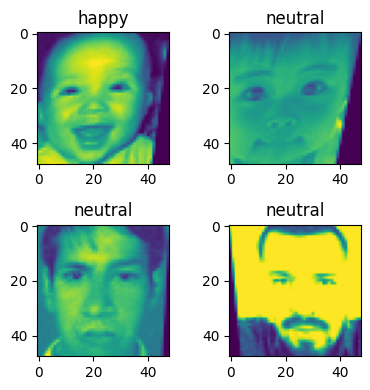

In [ ]:
# Set the size of the canvas
fig = plt.figure(figsize=(4, 4))
# Plot 4 images in 2 rows and 2 columns
for i in range(1, 5, 1):
  # Create a random index which is the image to be plotted
  random_index = np.random.randint(0, len(x_train))
  plt.subplot(2, 2, i)
  # Plot the image
  plt.imshow(np.array(x_train[random_index], np.int32))
  # Set the title of the image as the emotion
  plt.title(y_train[random_index])

plt.tight_layout()
plt.show()

In [ ]:
image_shape = (x_train.shape[1], x_train.shape[2], 1)

## Check Distribution of the Classes

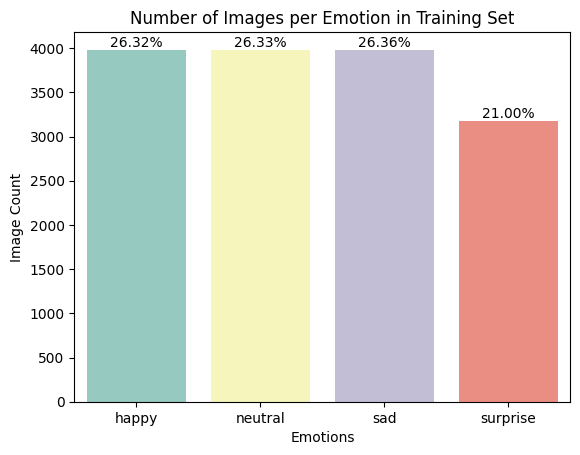

In [ ]:
# Get the value counts for each class in the training set
tp_train_class_counts = np.unique(y_train, return_counts=True)
# Calculate the total number of images in training set
total_sum = sum(tp_train_class_counts[1])
# Calculate the percentages for each class in the trainin set
label_percentages = [(val / total_sum) * 100 for val in tp_train_class_counts[1]]

# Create a bar plot
ax = sb.countplot(x=y_train, palette='Set3')

# Annotate the bars with percentages
for i, val in enumerate(label_percentages):
    ax.text(i, tp_train_class_counts[1][i] + 2, f'{val:.2f}%', ha='center', va='bottom')

# Set labels for x and y axes
plt.xlabel('Emotions')
plt.ylabel('Image Count')

# Set the labels for each bar
plt.xticks(range(len(tp_train_class_counts[1])), emotions)

# Title for the plot
plt.title('Number of Images per Emotion in Training Set')

# Show the plot
plt.show()

🔎 **Observations:** As you can see in **Number of Images per Emotion** plot, the training set is almost balanced. That's why we can only focus on the **accuracy score** metric. However, we might need to pay attention to how the model is performing for the surprise emotion since it has the least number of images.

# Solution Design


In [ ]:
def plot_training_history(history, nr_epochs, title='Training History'):
  '''
    This function plots the history of training and validation accuracy and
    the loss so the model builder can decide if the proposed model sufferes
    from overfitting or underfitting.
    ---
    ## Parameters
    - history <history>: History object of the training process.
    - nr_epochs <integer>: Number of epochs used to train the model to format the ticks of the plot.
    - title <string>: Title of the plot to be displayed at the top.
  '''
  plt.figure(figsize=(12, 5))
  # Plot the training accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  # Plot the accuracy of the validaiton set
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.xticks(np.arange(0, nr_epochs, step=2))
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'], loc='upper left')

  # Plot the training loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  # Plot the loss of the validaiton set
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.xticks(np.arange(0, nr_epochs, step=2))
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.suptitle(title)
  plt.show()

## Encode the Labels

In [ ]:
# Converting the string values into integers by using LabelEncoder
label_encoder = LabelEncoder()

# Converting them into categorical values
y_train_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_train))
y_validation_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_validation))
y_test_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_test))

## First CNN Model

In this model, we'll use some convolutional layers and dense layers without any regularization technique like `BatchNormalization` or `Dropout` to see if the model suffers from overfitting.

In [ ]:
# Let's clear the session to start a new training.
# This process will be repeated before each new model training
backend.clear_session()
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### Model Building

In [ ]:
kernel = (3, 3) # Setting the kernel size for the model
model_cnn_1 = Sequential()

# Adding first convolutional block
model_cnn_1.add(Conv2D(64, kernel, padding='same', input_shape=image_shape, name='block_1_conv1'))
model_cnn_1.add(LeakyReLU(0.1, name='block_1_activation1'))
model_cnn_1.add(MaxPooling2D(2, 2, name='block_1_pool1'))

# Adding second convolutional block
model_cnn_1.add(Conv2D(128, kernel, padding='same', name='block_2_conv1'))
model_cnn_1.add(LeakyReLU(0.1, name='block_2_activation1'))
model_cnn_1.add(MaxPooling2D(2, 2, name='block_2_pool1'))

# Adding third convolutional block
model_cnn_1.add(Conv2D(32, kernel, padding='same', name='block_3_conv1'))
model_cnn_1.add(LeakyReLU(0.1, name='block_3_activation1'))
model_cnn_1.add(MaxPooling2D(2, 2, name='block_3_pool1'))

# Add the Flatten layer
model_cnn_1.add(Flatten())

# Add the first Dense layer
model_cnn_1.add(Dense(64, activation='relu'))

# Add the output layer
model_cnn_1.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_cnn_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

# Print the summary of the model
model_cnn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_1_conv1 (Conv2D)      (None, 48, 48, 64)        640       
                                                                 
 block_1_activation1 (Leaky  (None, 48, 48, 64)        0         
 ReLU)                                                           
                                                                 
 block_1_pool1 (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 block_2_conv1 (Conv2D)      (None, 24, 24, 128)       73856     
                                                                 
 block_2_activation1 (Leaky  (None, 24, 24, 128)       0         
 ReLU)                                                           
                                                        

### Training the Model

Epoch 1/30
473/473 [==============================] - 15s 10ms/step - loss: 1.7811 - accuracy: 0.3133 - val_loss: 1.3637 - val_accuracy: 0.3347
Epoch 2/30
473/473 [==============================] - 4s 9ms/step - loss: 1.2916 - accuracy: 0.3967 - val_loss: 1.3301 - val_accuracy: 0.3556
Epoch 3/30
473/473 [==============================] - 5s 10ms/step - loss: 1.2280 - accuracy: 0.4534 - val_loss: 1.1668 - val_accuracy: 0.4965
Epoch 4/30
473/473 [==============================] - 4s 9ms/step - loss: 1.1479 - accuracy: 0.4997 - val_loss: 1.0661 - val_accuracy: 0.5363
Epoch 5/30
473/473 [==============================] - 4s 9ms/step - loss: 1.0703 - accuracy: 0.5485 - val_loss: 1.0330 - val_accuracy: 0.5742
Epoch 6/30
473/473 [==============================] - 4s 8ms/step - loss: 0.9936 - accuracy: 0.5885 - val_loss: 0.9226 - val_accuracy: 0.6138
Epoch 7/30
473/473 [==============================] - 4s 8ms/step - loss: 0.9283 - accuracy: 0.6135 - val_loss: 0.9444 - val_accuracy: 0.6293
Epo

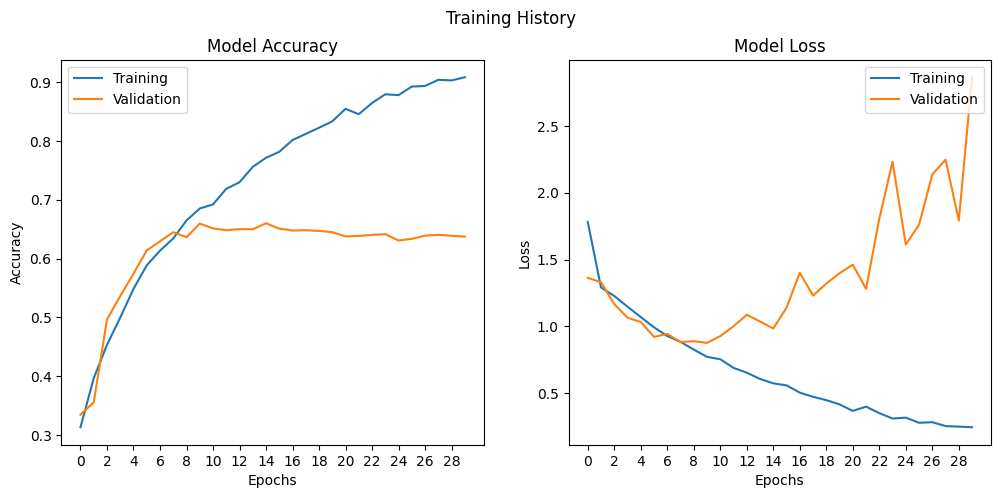

In [ ]:
nr_epochs = 30
history_cnn_1 = model_cnn_1.fit(
    x = x_train,
    y = y_train_encoded,
    validation_data = (x_validation, y_validation_encoded),
    epochs = nr_epochs,
    verbose = 1
)

plot_training_history(history_cnn_1, nr_epochs)

### Evaluating the Model

In [ ]:
print(f'Accuracy Score: {model_cnn_1.evaluate(x_test, y_test_encoded, verbose=0)[1]*100:.2f}%')

Accuracy Score: 65.62%


🔎 **Observations:** The accuracy has a good score however, it's not good enough to say that the model is performing well. The proposed model has 185,444 trainable parameters and it took 10 minutes to complete the 30-epoch training. Considering the ups and downs of the validatio accuracy on the history plot, it seems that we shoul stop the training after a couple of down by using `EarlyStopping`. In addition to this, considering the gap between training and validation accuracy it's easy to notice that the model suffers from overfitting. Which means that we need to add some regularization methods to the next model.

## Second CNN Model

I'm going add `GlobalAveragePooling2D` as I know it has a positive contribution to the performance of the model more than `Flatten` layer. Also, I'm going to use `AdamW` instead of `Adam` optimizer. However, I wanted to be sure that the model's performance is not overly dependent on the initial random weights. **Cross-validation** helps in providing a more robust estimate of a model's performance. I'll use 10-fold `StratifiedCrossValidation` as the number of images for the **surprised** faceses are a little less than the rest of the emotions. 10-fold cross validation means that each model architecture performance will be evaluatted 10 times which will take a lot of time. That's why we'll implement `EarlyStopping` mechanism to the model training procedure in case the validation accuracy does not improve for a certain amount of epochs.

I'm **not** going to clear the session of the `backend` between cross-validation folds as Clearing the session adds some overhead in terms of time because it resets the Keras backend and I assume Google Colab provides me sufficent GPU memory.



In [ ]:
# Let's clear the session to start a new training.
# This process will be repeated before each new model training
backend.clear_session()
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Create the early stopping criteria
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    verbose = 1,
    min_delta = 0.1,
    patience = 10,
    restore_best_weights = True
)

# Create the check point to save the best model
# checkpoint = ModelCheckpoint(
#     root_path + 'Models/model_cnn2_rgb.h5',
#     monitor = 'val_accuracy',
#     verbose = 1,
#     save_best_only = True,
#     mode = 'max'
# )

# Reduce the learning rate if the validation accuracy does not change for a while
reduce_learningrate = ReduceLROnPlateau(
    monitor = 'accuracy',
    verbose = 1,
    min_delta = 0.0001,
    patience = 3,
)

callback_list = [early_stopping, reduce_learningrate]

### Model Building

In [ ]:
def create_model_1():
  kernel = (3, 3) # Setting the kernel size for the model
  model_cnn = Sequential()

  # Adding first convolutional block
  model_cnn.add(Conv2D(64, kernel, padding='same', input_shape=image_shape, name='block_1_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_1_activation1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_1_pool1'))

  # Adding second convolutional block
  model_cnn.add(Conv2D(128, kernel, padding='same', name='block_2_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_2_activation1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_2_pool1'))

  # Adding third convolutional block
  model_cnn.add(Conv2D(32, kernel, padding='same', name='block_3_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_3_activation1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_3_pool1'))

  # Add the Flatten layer
  model_cnn.add(GlobalAveragePooling2D())

  # Add the first Dense layer
  model_cnn.add(Dense(64, activation='relu'))

  # Add the output layer
  model_cnn.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model_cnn.compile(
      loss = 'categorical_crossentropy',
      optimizer = Adam(learning_rate=0.001),
      metrics = ['accuracy']
  )

  return model_cnn

### Cross-Validation of the Model

In [ ]:
def cross_validate(create_model):
  cv_scores_acc = []   # to store the validation accuracy of each fold
  cv_scores_loss = []  # to store the validation loss of each fold
  k_number = 10       # Number of folds

  # Initialize KFold cross-validator
  kf = StratifiedKFold(n_splits=k_number, shuffle=True, random_state=seed)
  label_encoder = LabelEncoder()
  nr_epochs = 30
  i = 1
  # Perform k-fold cross-validation on the training set
  for train_index, val_index in kf.split(x_train, y_train):

    x_fold_train, x_fold_val = x_train[train_index], x_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

    y_fold_train_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_fold_train))
    y_fold_val_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_fold_val))
    y_val_encoded = tf.keras.utils.to_categorical(label_encoder.fit_transform(y_validation))

    model = create_model()

    # Train the model on the training set
    history = model.fit(
        x = x_fold_train, y = y_fold_train_encoded,
        validation_data=(x_fold_val, y_fold_val_encoded),
        epochs = nr_epochs,
        callbacks = callback_list,
        verbose=0
        )

    plot_training_history(history, nr_epochs)

    # Evaluate the model on the validation set
    eval_result = model.evaluate(x=x_validation, y=y_val_encoded, verbose=0)
    cv_scores_acc.append(eval_result[1])
    cv_scores_loss.append(eval_result[0])
    print('='*70)
    print(f'Accuracy of Fold {i}: {eval_result[1]*100:.2f}%')
    print('='*70)
    print('\n') # Seet some space

    i+=1

  # Calculate and print the average evaluation results across folds
  average_loss = np.mean(cv_scores_loss)
  average_accuracy = np.mean(cv_scores_acc)

  print('\n') # Seet some space
  print('*'*70)
  print(cv_scores_acc)
  print('-'*70)
  print(f'Average Loss: {average_loss:.2f}')
  print(f'Average Accuracy: {average_accuracy*100:.2f}%')


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


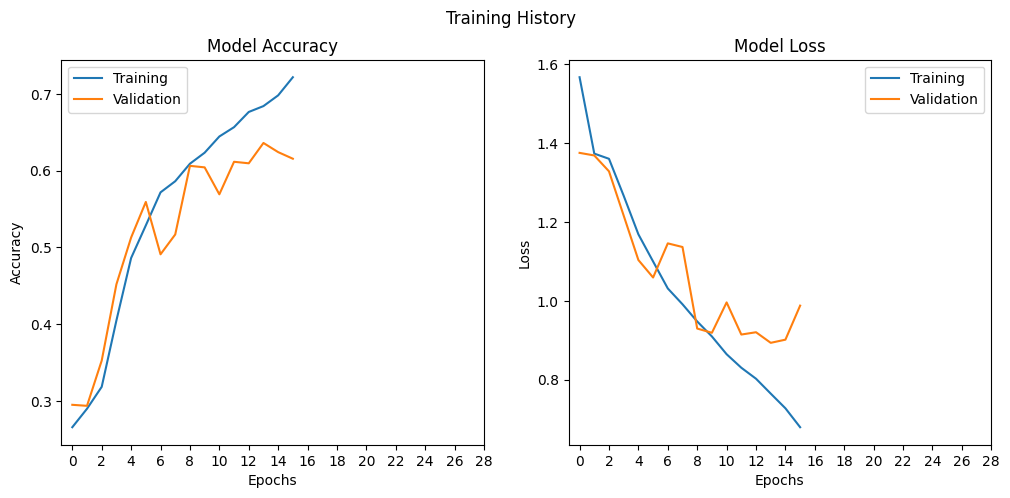

Accuracy of Fold 1: 57.89%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


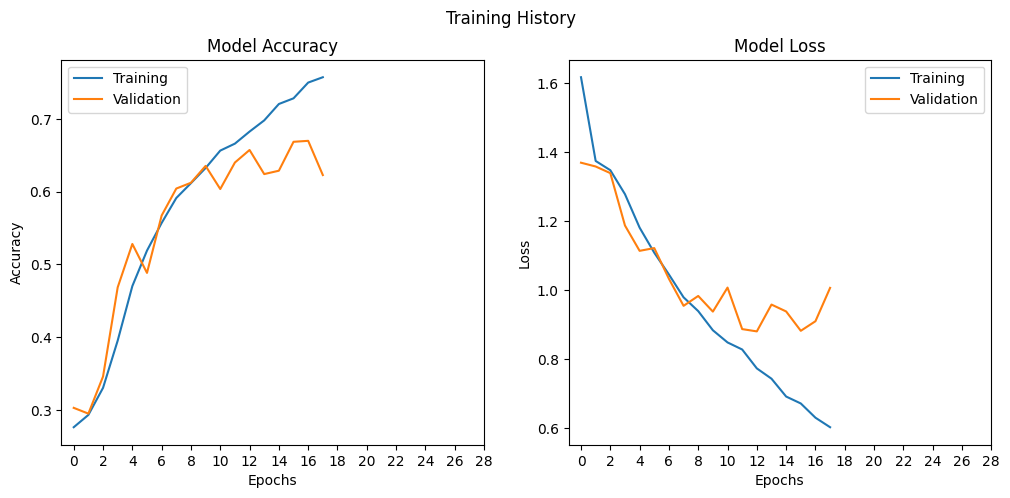

Accuracy of Fold 2: 60.04%


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


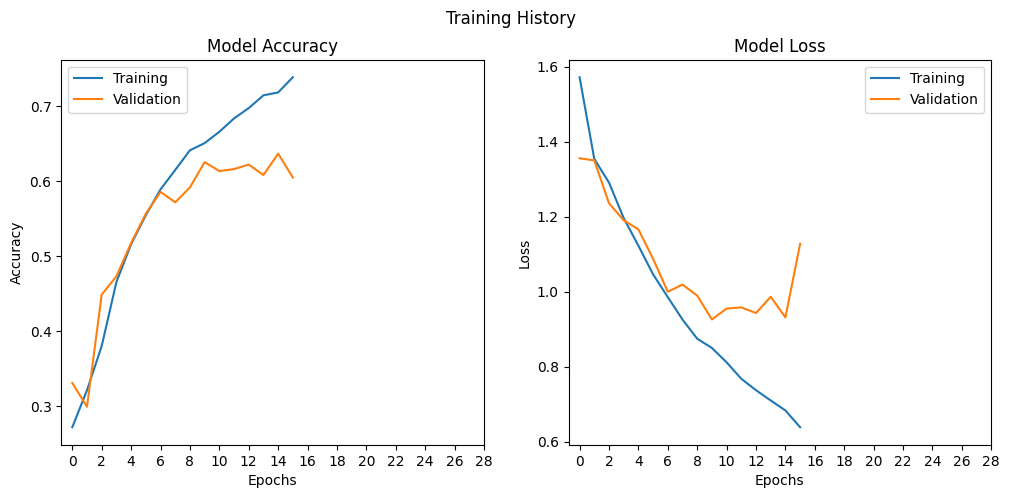

Accuracy of Fold 3: 58.15%


Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping


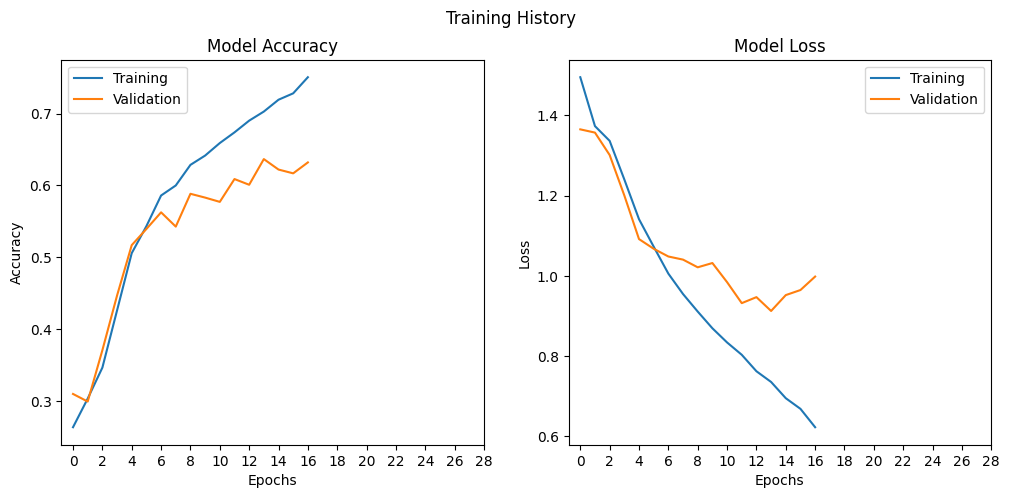

Accuracy of Fold 4: 61.02%


Restoring model weights from the end of the best epoch: 4.
Epoch 14: early stopping


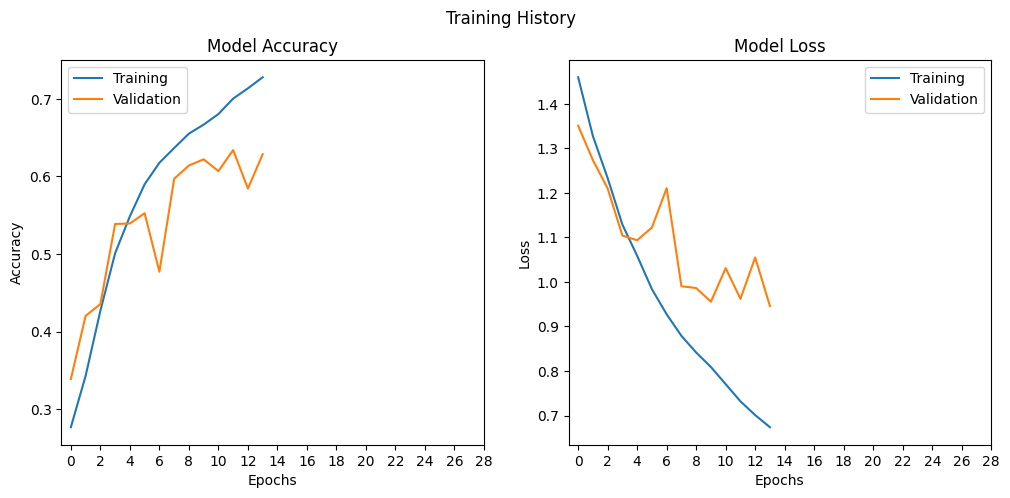

Accuracy of Fold 5: 58.01%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


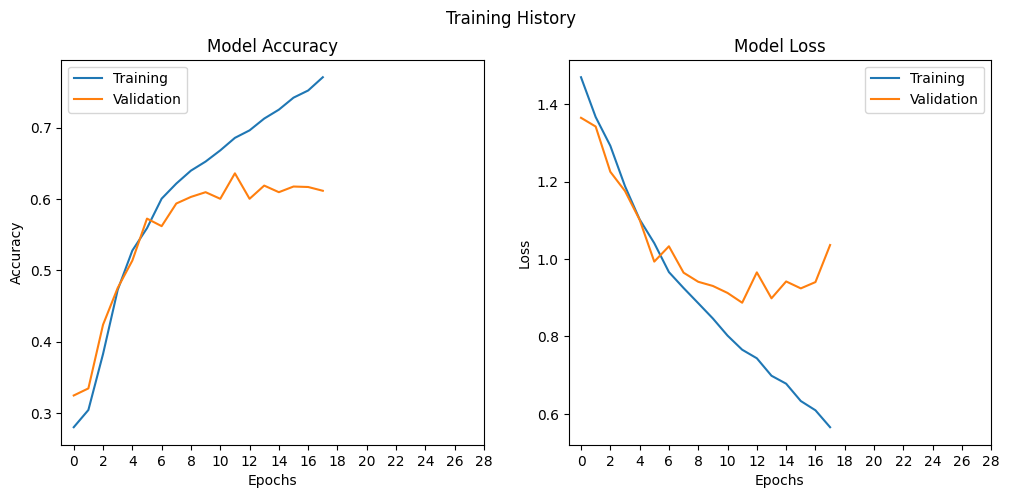

Accuracy of Fold 6: 63.93%


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


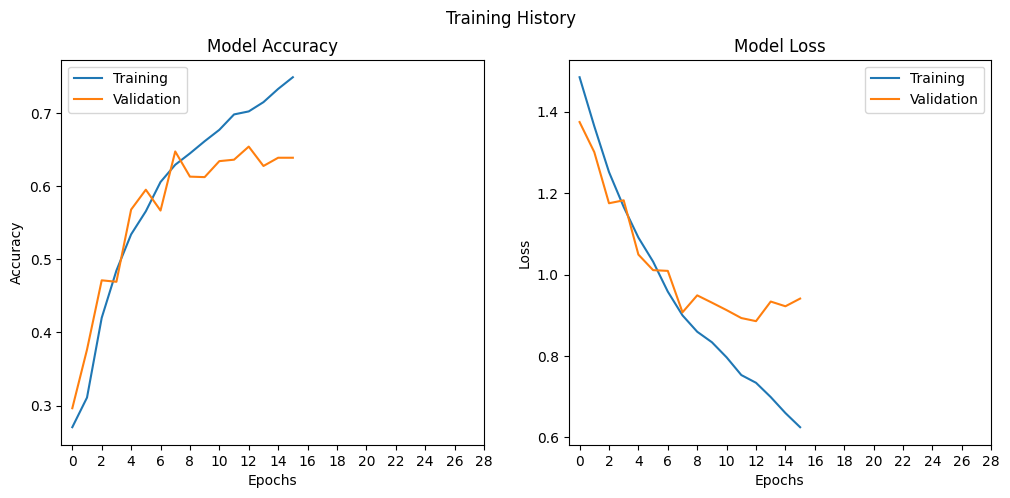

Accuracy of Fold 7: 59.35%


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


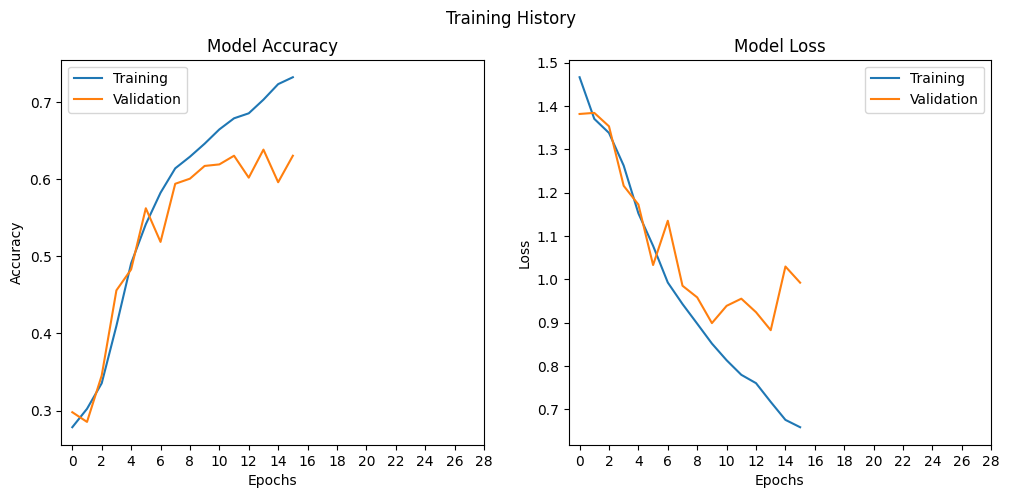

Accuracy of Fold 8: 59.37%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


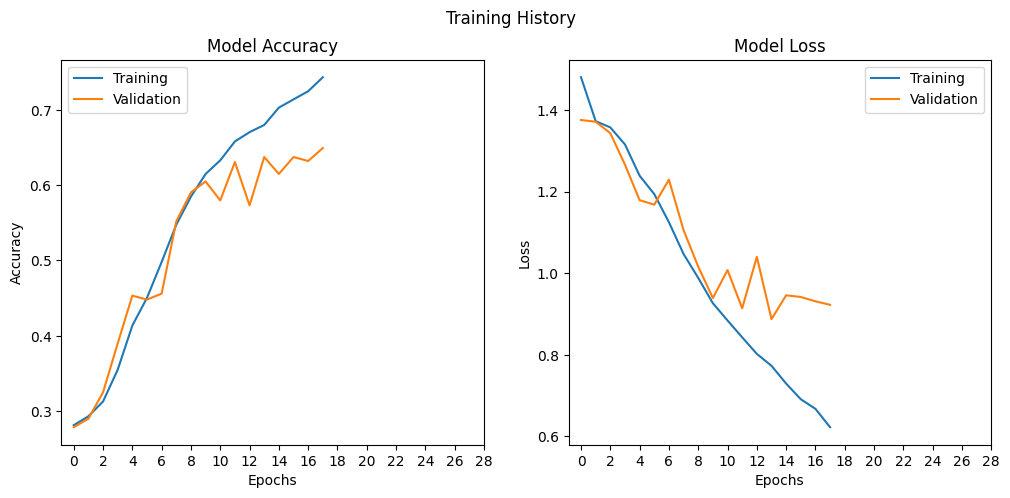

Accuracy of Fold 9: 54.57%


Restoring model weights from the end of the best epoch: 7.
Epoch 17: early stopping


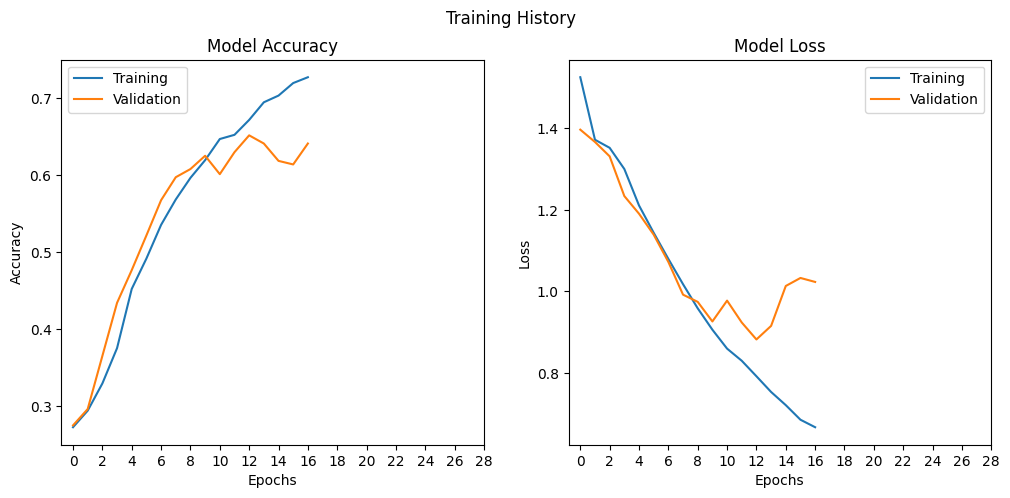

Accuracy of Fold 10: 59.31%




**********************************************************************
[0.5788627862930298, 0.6003616452217102, 0.581474781036377, 0.6102069616317749, 0.5800682902336121, 0.6393409967422485, 0.5935302376747131, 0.593731164932251, 0.5457102656364441, 0.5931283831596375]
----------------------------------------------------------------------
Average Loss: 0.97
Average Accuracy: 59.16%


In [ ]:
cross_validate(create_model_1)

🔎 **Observations:** As you can see in the training history plots, there is a big gap between the training and validation accuracy towards the end of the training. This means that the model suffers from overfitting. That's why we'll start using regularization techniques. But this will decrease the accuracy score of the training. To prevent this, we'll increase the number of fully connected layers.

## Third CNN Model

In [ ]:
# Let's clear the session to start a new training.
# This process will be repeated before each new model training
backend.clear_session()
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### Model Building

In [ ]:
def create_model_2():
  kernel = (3, 3) # Setting the kernel size for the model
  model_cnn = Sequential()

  # Adding first convolutional block
  model_cnn.add(Conv2D(64, kernel, padding='same', input_shape=image_shape, name='block_1_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_1_activation1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_1_pool1'))

  # Adding second convolutional block
  model_cnn.add(Conv2D(128, kernel, padding='same', name='block_2_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_2_activation1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_2_pool1'))

  # Adding third convolutional block
  model_cnn.add(Conv2D(32, kernel, padding='same', name='block_3_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_3_activation1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_3_pool1'))

  # Add the Flatten layer
  model_cnn.add(GlobalAveragePooling2D())

  # Add the first Dense layer
  model_cnn.add(Dense(64, activation='relu'))
  model_cnn.add(Dropout(0.2))
  # Add the second Dense layer
  model_cnn.add(Dense(128, activation='relu'))
  model_cnn.add(Dropout(0.4))
  # Add the third Dense layer
  model_cnn.add(Dense(64, activation='relu'))
  model_cnn.add(Dropout(0.2))

  # Add the output layer
  model_cnn.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model_cnn.compile(
      loss = 'categorical_crossentropy',
      optimizer = Adam(learning_rate=0.001),
      metrics = ['accuracy']
  )

  return model_cnn

In [ ]:
create_model_2().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_1_conv1 (Conv2D)      (None, 48, 48, 64)        640       
                                                                 
 block_1_activation1 (Leaky  (None, 48, 48, 64)        0         
 ReLU)                                                           
                                                                 
 block_1_pool1 (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 block_2_conv1 (Conv2D)      (None, 24, 24, 128)       73856     
                                                                 
 block_2_activation1 (Leaky  (None, 24, 24, 128)       0         
 ReLU)                                                           
                                                        

### Cross-Validation of the Model

Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


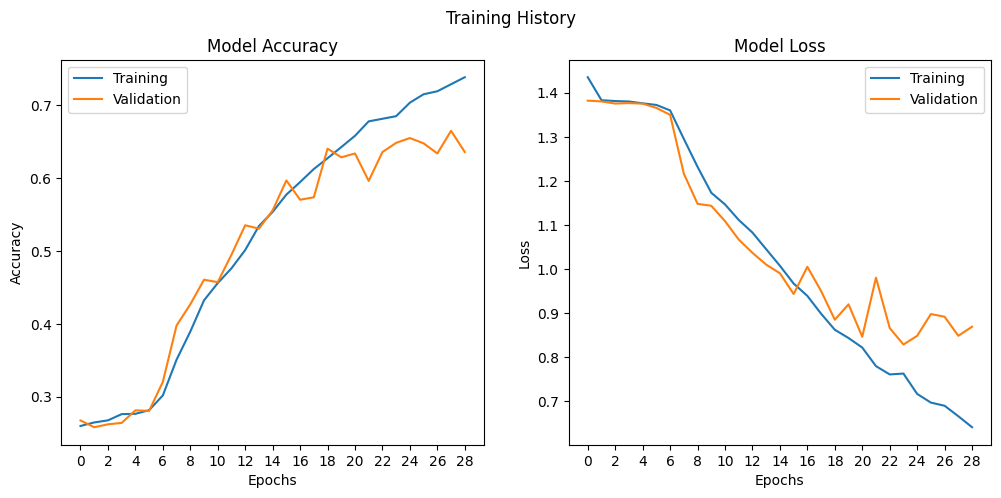

Accuracy of Fold 1: 63.35%


Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping


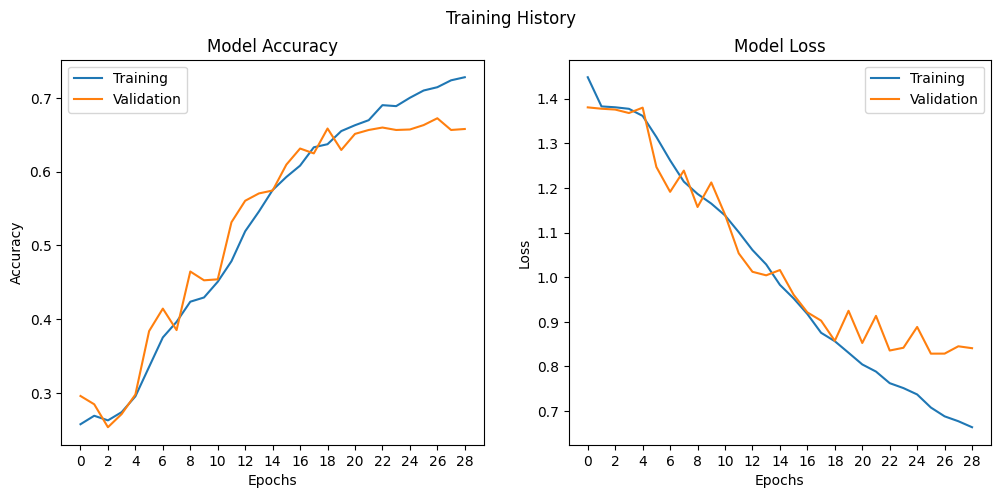

Accuracy of Fold 2: 65.06%




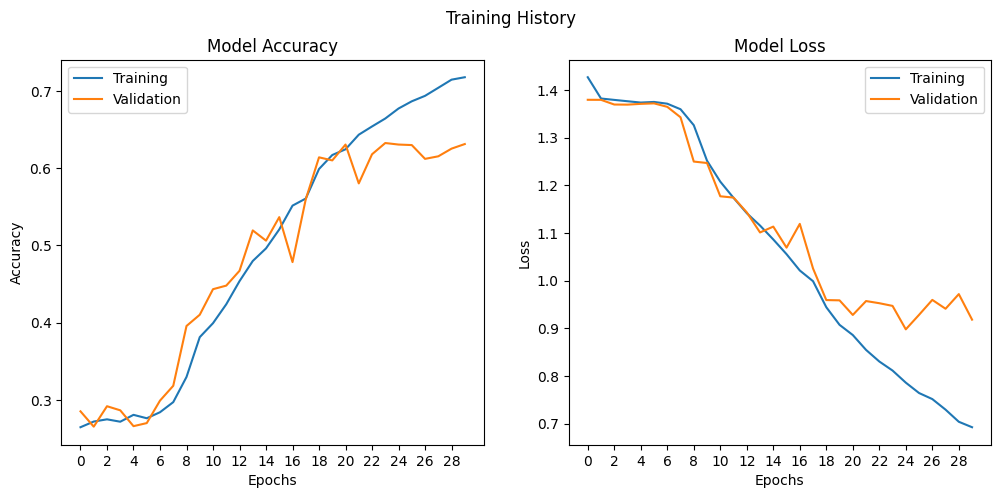

Accuracy of Fold 3: 65.24%




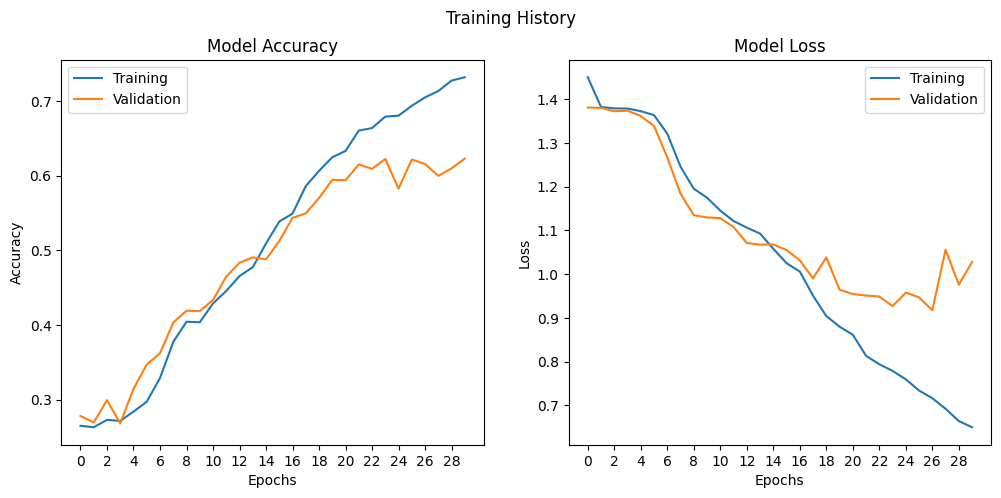

Accuracy of Fold 4: 67.13%


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


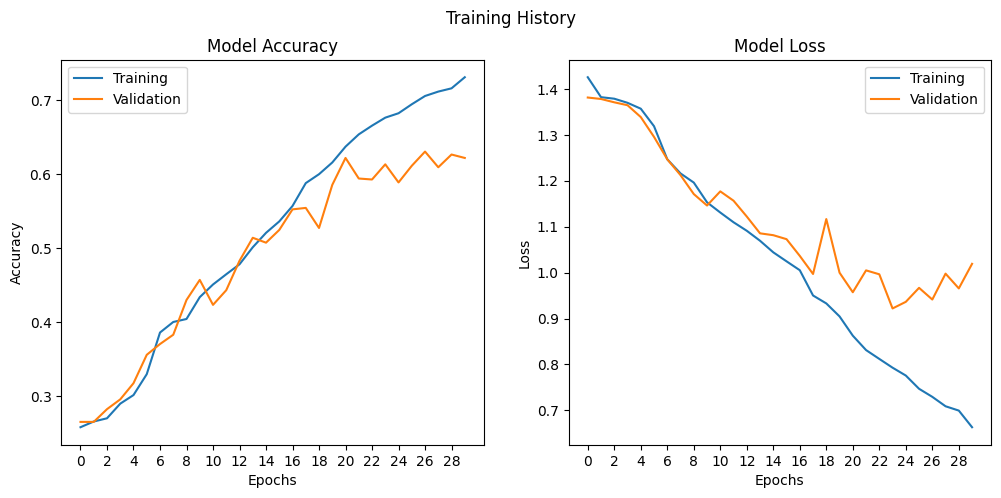

Accuracy of Fold 5: 62.47%




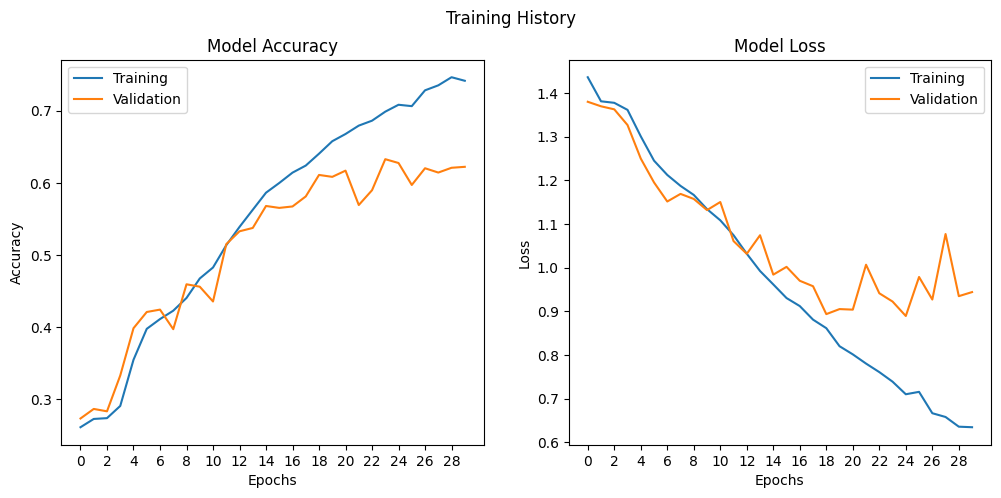

Accuracy of Fold 6: 65.54%


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


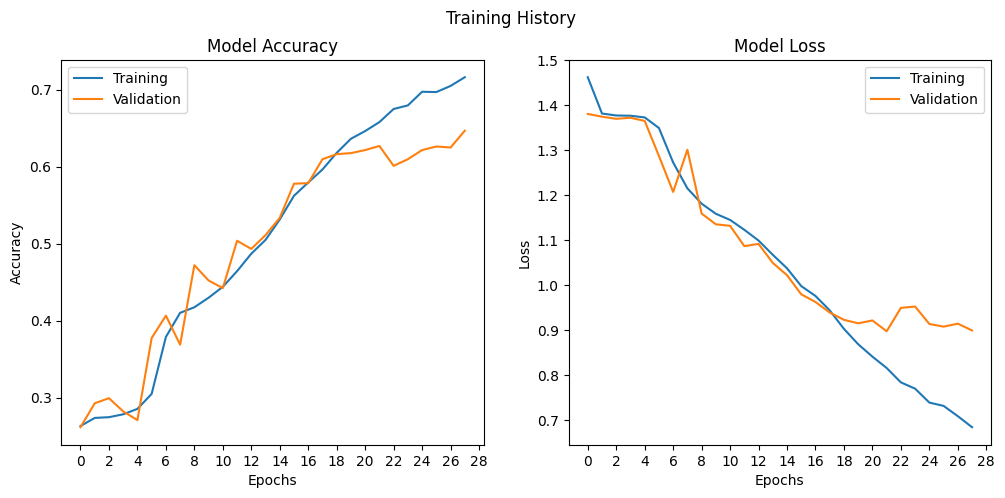

Accuracy of Fold 7: 61.76%


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


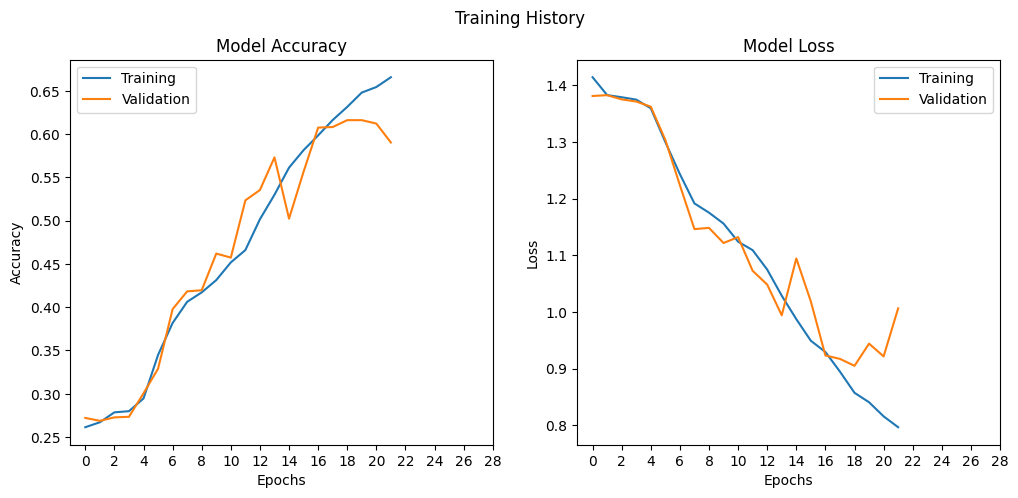

Accuracy of Fold 8: 51.70%


Restoring model weights from the end of the best epoch: 20.
Epoch 30: early stopping


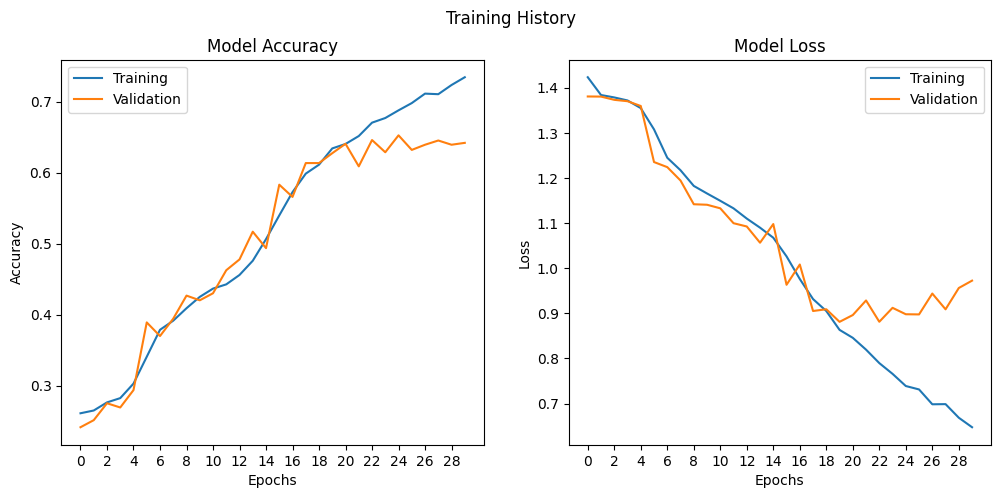

Accuracy of Fold 9: 63.95%


Restoring model weights from the end of the best epoch: 18.
Epoch 28: early stopping


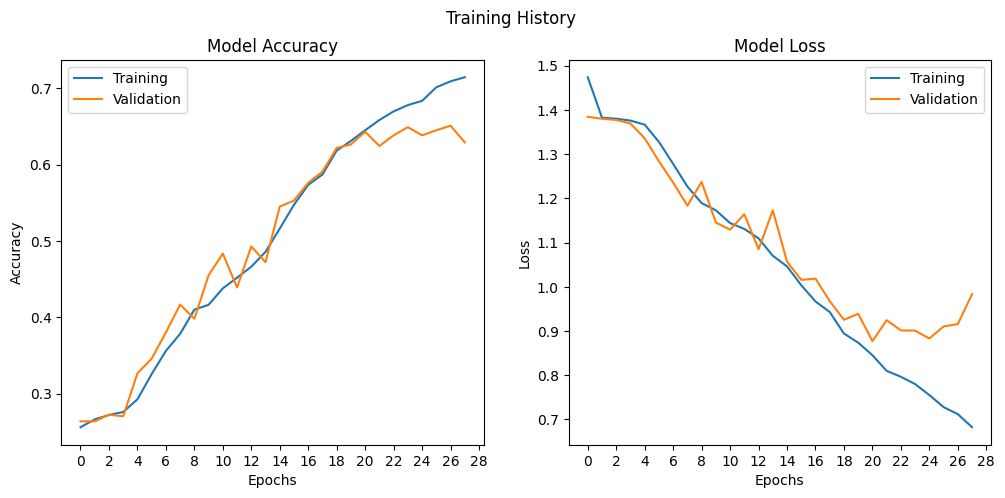

Accuracy of Fold 10: 57.34%




**********************************************************************
[0.6335141658782959, 0.6505927443504333, 0.6524010300636292, 0.6712879538536072, 0.6246734857559204, 0.655414879322052, 0.6176411509513855, 0.5169780850410461, 0.6395418643951416, 0.5734378099441528]
----------------------------------------------------------------------
Average Loss: 0.94
Average Accuracy: 62.35%


In [ ]:
cross_validate(create_model_2)

🔎 **Observations:** It looks like adding more parameters some penalties to the model worked well. However, the performance of the model still is not in the range that we desire. That's why we'll keep adding more penalties and more nodes to the model.

## Fourth CNN Model

In [ ]:
# Let's clear the session to start a new training.
# This process will be repeated before each new model training
backend.clear_session()
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### Model Building

In [ ]:
def create_model_3():
  kernel = (3, 3) # Setting the kernel size for the model
  model_cnn = Sequential()

  # Adding first convolutional block
  model_cnn.add(Conv2D(64, kernel, padding='same', input_shape=image_shape, name='block_1_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_1_activation1'))
  model_cnn.add(BatchNormalization(name='block_1_batch_normalization1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_1_pool1'))


  # Adding second convolutional block
  model_cnn.add(Conv2D(128, kernel, padding='same', name='block_2_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_2_activation1'))
  model_cnn.add(BatchNormalization(name='block_2_batch_normalization1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_2_pool1'))


  # Adding third convolutional block
  model_cnn.add(Conv2D(32, kernel, padding='same', name='block_3_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_3_activation1'))
  model_cnn.add(BatchNormalization(name='block_3_batch_normalization1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_3_pool1'))

  # Add the Flatten layer
  model_cnn.add(GlobalAveragePooling2D())

  # Add the first Dense layer
  model_cnn.add(Dense(128, activation='relu'))
  model_cnn.add(Dropout(0.2))
  # Add the second Dense layer
  model_cnn.add(Dense(512, activation='relu'))
  model_cnn.add(Dropout(0.4))
  # Add the third Dense layer
  model_cnn.add(Dense(64, activation='relu'))
  model_cnn.add(Dropout(0.2))

  # Add the output layer
  model_cnn.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model_cnn.compile(
      loss = 'categorical_crossentropy',
      optimizer = Adam(learning_rate=0.001),
      metrics = ['accuracy']
  )

  return model_cnn

In [ ]:
create_model_3().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_1_conv1 (Conv2D)      (None, 48, 48, 64)        640       
                                                                 
 block_1_activation1 (Leaky  (None, 48, 48, 64)        0         
 ReLU)                                                           
                                                                 
 block_1_batch_normalizatio  (None, 48, 48, 64)        256       
 n1 (BatchNormalization)                                         
                                                                 
 block_1_pool1 (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 block_2_conv1 (Conv2D)      (None, 24, 24, 128)       73856     
                                                        

### Cross-Validation of the Model

Restoring model weights from the end of the best epoch: 5.
Epoch 15: early stopping


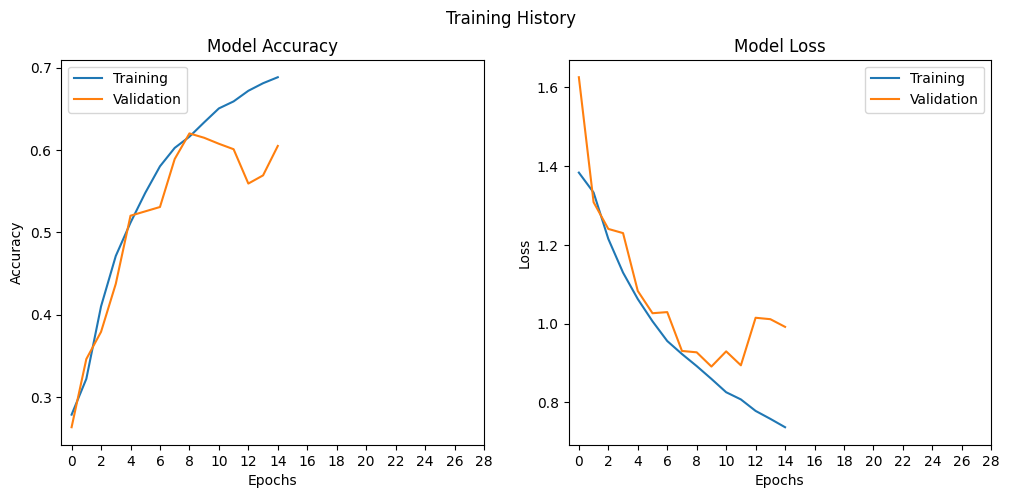

Accuracy of Fold 1: 54.99%


Restoring model weights from the end of the best epoch: 9.
Epoch 19: early stopping


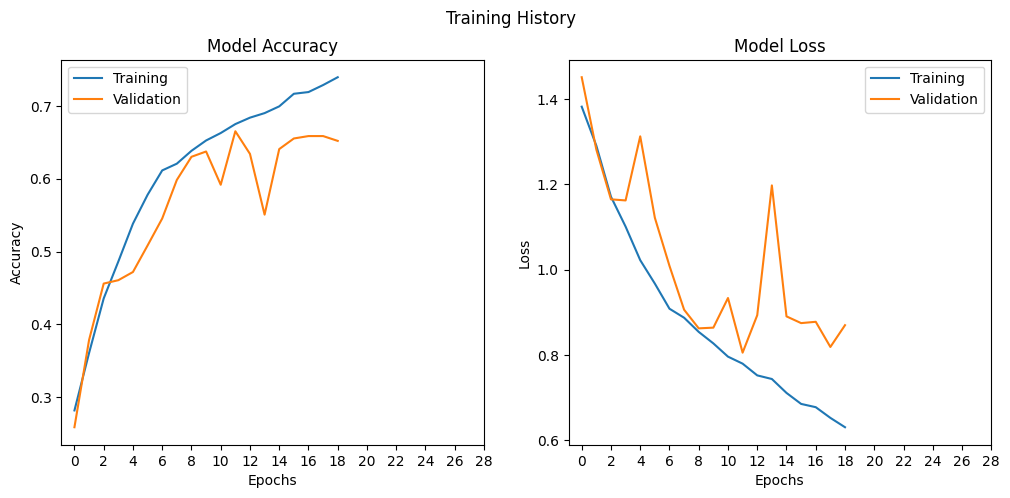

Accuracy of Fold 2: 65.96%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


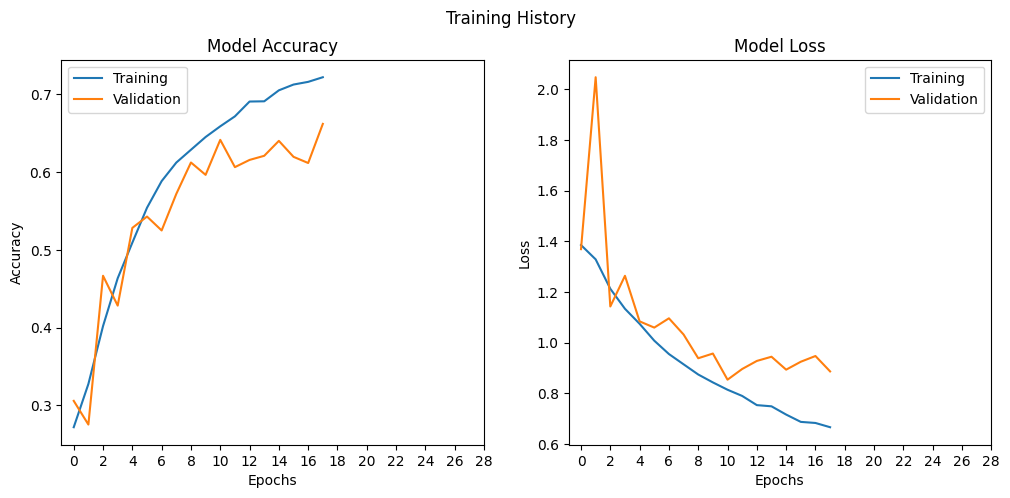

Accuracy of Fold 3: 62.99%


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


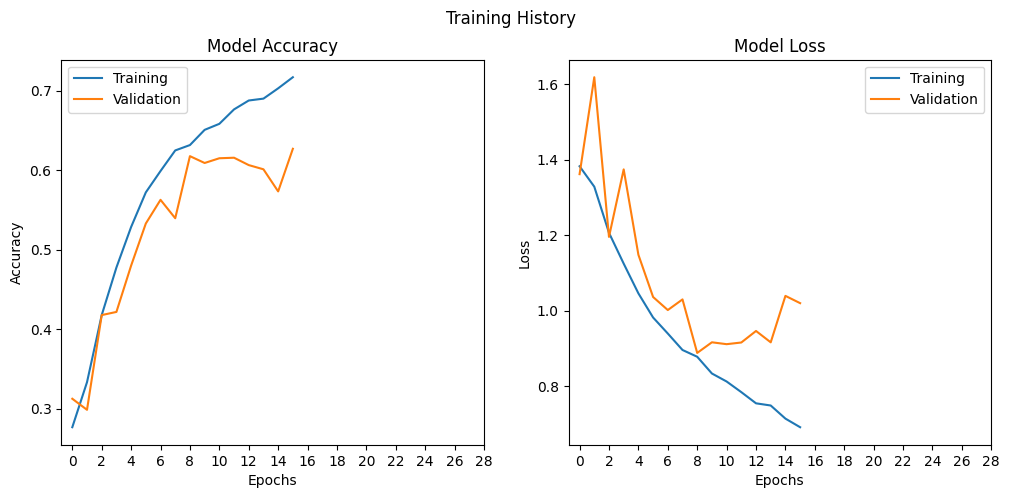

Accuracy of Fold 4: 52.82%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


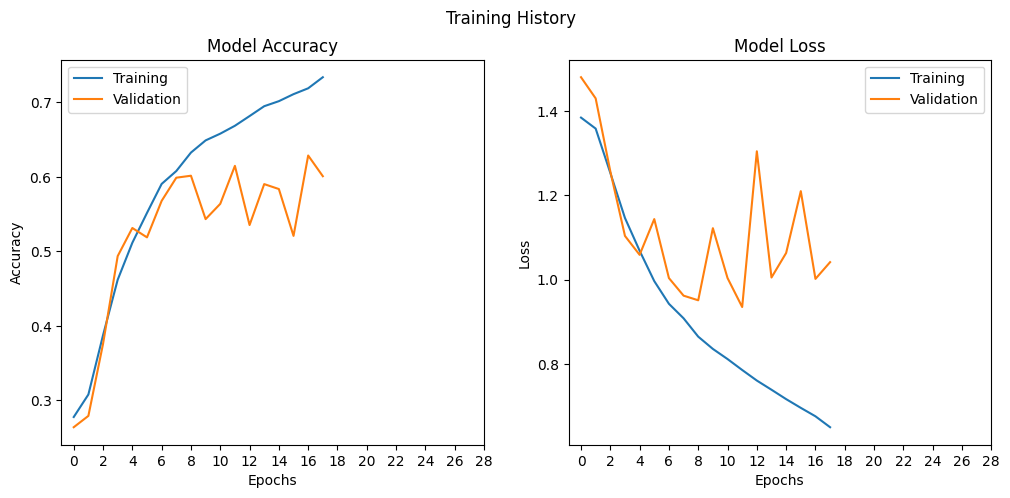

Accuracy of Fold 5: 65.68%


Restoring model weights from the end of the best epoch: 10.
Epoch 20: early stopping


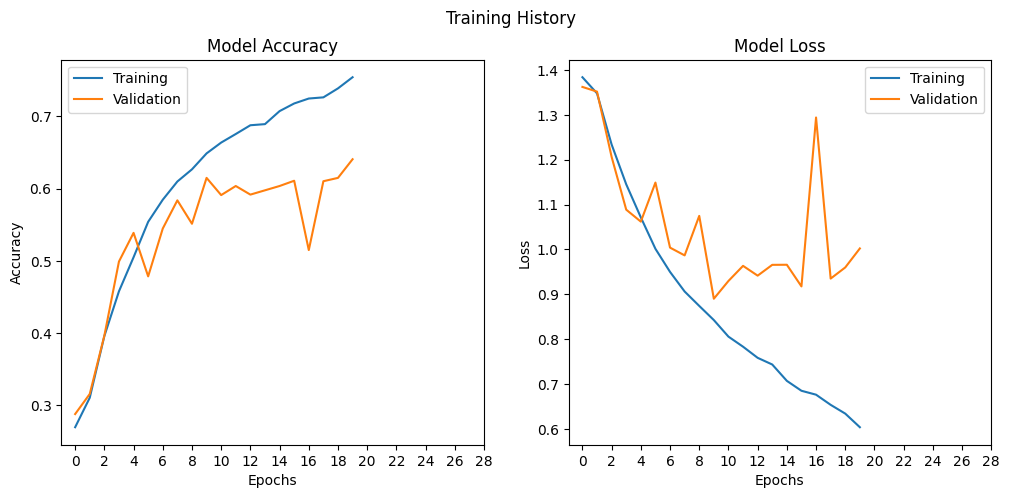

Accuracy of Fold 6: 67.85%


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


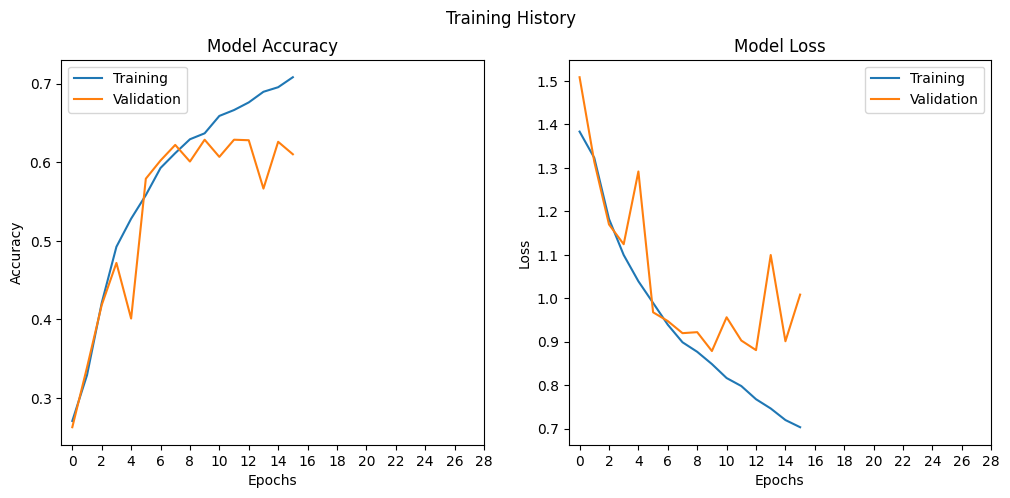

Accuracy of Fold 7: 63.65%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


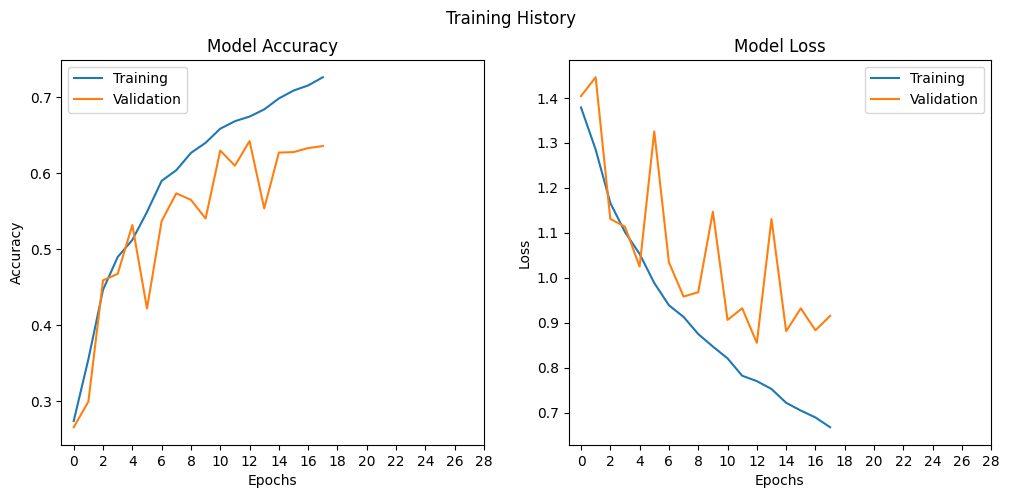

Accuracy of Fold 8: 63.05%


Restoring model weights from the end of the best epoch: 6.
Epoch 16: early stopping


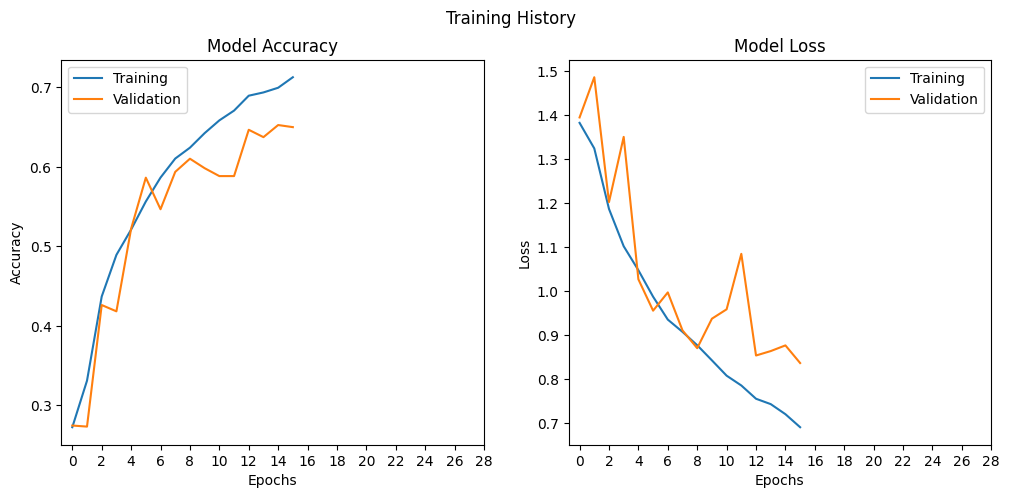

Accuracy of Fold 9: 61.46%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


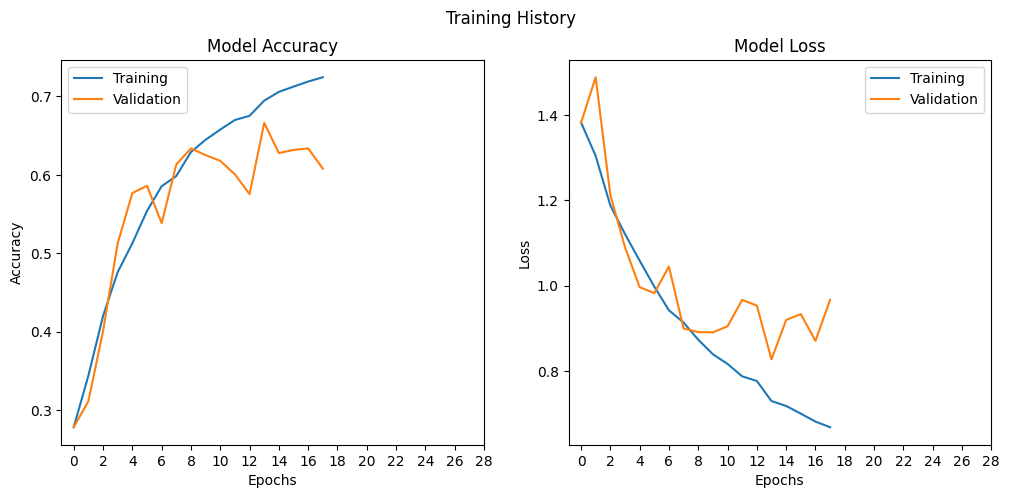

Accuracy of Fold 10: 63.67%




**********************************************************************
[0.549929678440094, 0.6596342921257019, 0.6298975348472595, 0.528229832649231, 0.6568213701248169, 0.6785212159156799, 0.6365280151367188, 0.630500316619873, 0.6146273016929626, 0.6367289423942566]
----------------------------------------------------------------------
Average Loss: 0.90
Average Accuracy: 62.21%


In [ ]:
cross_validate(create_model_3)

🔎 **Observations:** It looks like we have almost the same results. Let's keep modifing the model.

## Fifth CNN Model

In [ ]:
# Let's clear the session to start a new training.
# This process will be repeated before each new model training
backend.clear_session()
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### Model Building

In [ ]:
def create_model_4():
  kernel = (3, 3) # Setting the kernel size for the model
  model_cnn = Sequential()

  # Adding first convolutional block
  model_cnn.add(Conv2D(64, kernel, padding='same', input_shape=image_shape, name='block_1_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_1_activation1'))
  model_cnn.add(BatchNormalization(name='block_1_batch_normalization1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_1_pool1'))


  # Adding second convolutional block
  model_cnn.add(Conv2D(256, kernel, padding='same', name='block_2_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_2_activation1'))
  model_cnn.add(BatchNormalization(name='block_2_batch_normalization1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_2_pool1'))


  # Adding third convolutional block
  model_cnn.add(Conv2D(512, kernel, padding='same', name='block_3_conv1'))
  model_cnn.add(LeakyReLU(0.1, name='block_3_activation1'))
  model_cnn.add(BatchNormalization(name='block_3_batch_normalization1'))
  model_cnn.add(MaxPooling2D(2, 2, name='block_3_pool1'))

  # Add the Flatten layer
  model_cnn.add(GlobalAveragePooling2D())

  # Add the first Dense layer
  model_cnn.add(Dense(128, activation='relu'))
  model_cnn.add(Dropout(0.2))
  # Add the second Dense layer
  model_cnn.add(Dense(512, activation='relu'))
  model_cnn.add(Dropout(0.4))
  # Add the third Dense layer
  model_cnn.add(Dense(64, activation='relu'))
  model_cnn.add(Dropout(0.2))

  # Add the output layer
  model_cnn.add(Dense(num_classes, activation='softmax'))

  # Compile the model
  model_cnn.compile(
      loss = 'categorical_crossentropy',
      optimizer = AdamW(learning_rate=0.001),
      metrics = ['accuracy']
  )

  return model_cnn

In [ ]:
create_model_4().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block_1_conv1 (Conv2D)      (None, 48, 48, 64)        640       
                                                                 
 block_1_activation1 (Leaky  (None, 48, 48, 64)        0         
 ReLU)                                                           
                                                                 
 block_1_batch_normalizatio  (None, 48, 48, 64)        256       
 n1 (BatchNormalization)                                         
                                                                 
 block_1_pool1 (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 block_2_conv1 (Conv2D)      (None, 24, 24, 256)       147712    
                                                        

### Cross-Validation of the Model

Restoring model weights from the end of the best epoch: 17.
Epoch 27: early stopping


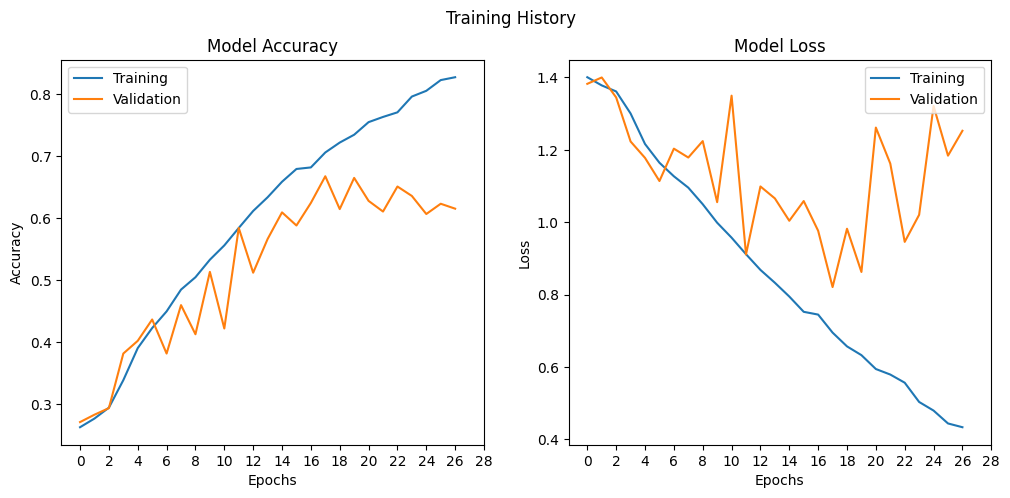

Accuracy of Fold 1: 62.89%


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


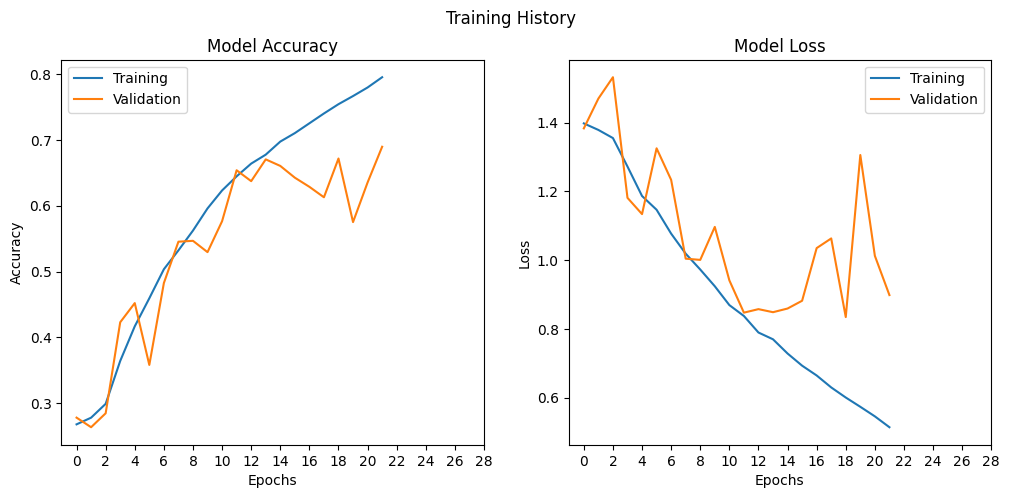

Accuracy of Fold 2: 68.31%


Restoring model weights from the end of the best epoch: 13.
Epoch 23: early stopping


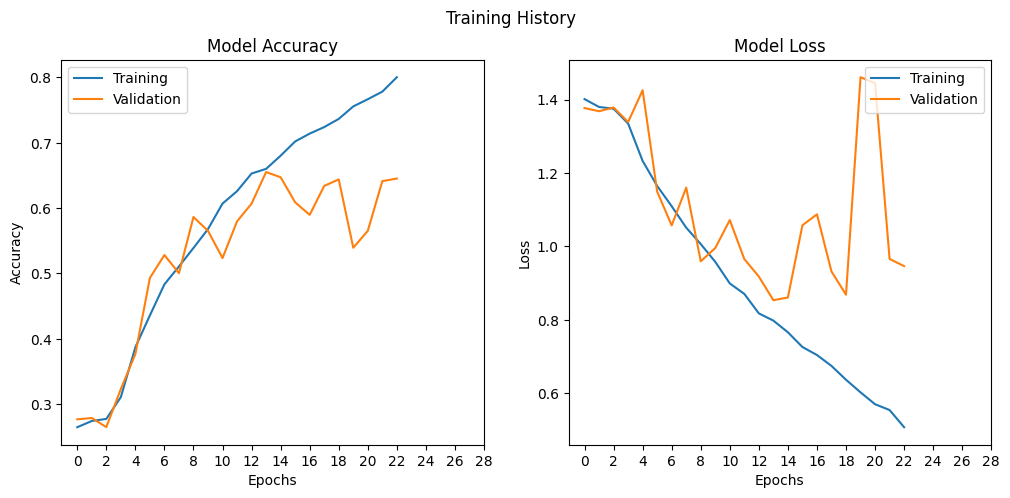

Accuracy of Fold 3: 64.22%


Restoring model weights from the end of the best epoch: 11.
Epoch 21: early stopping


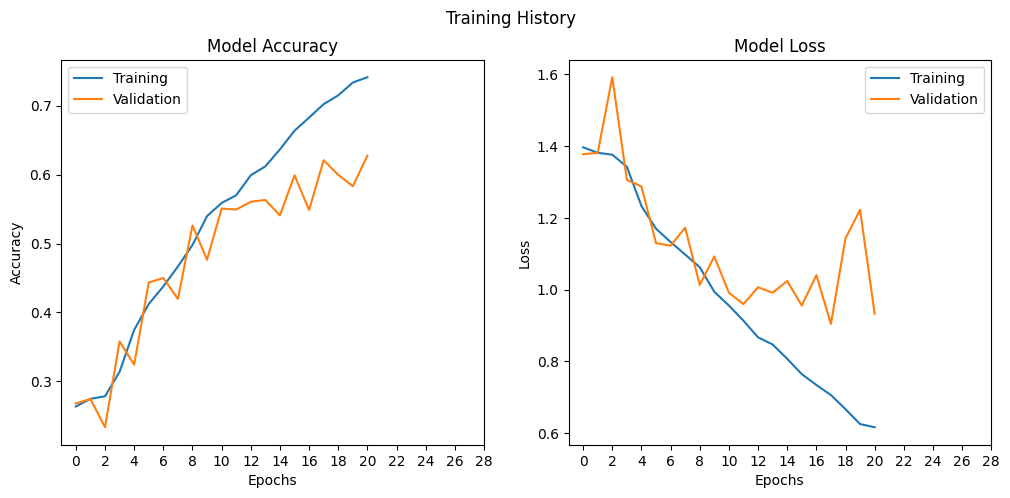

Accuracy of Fold 4: 58.67%


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


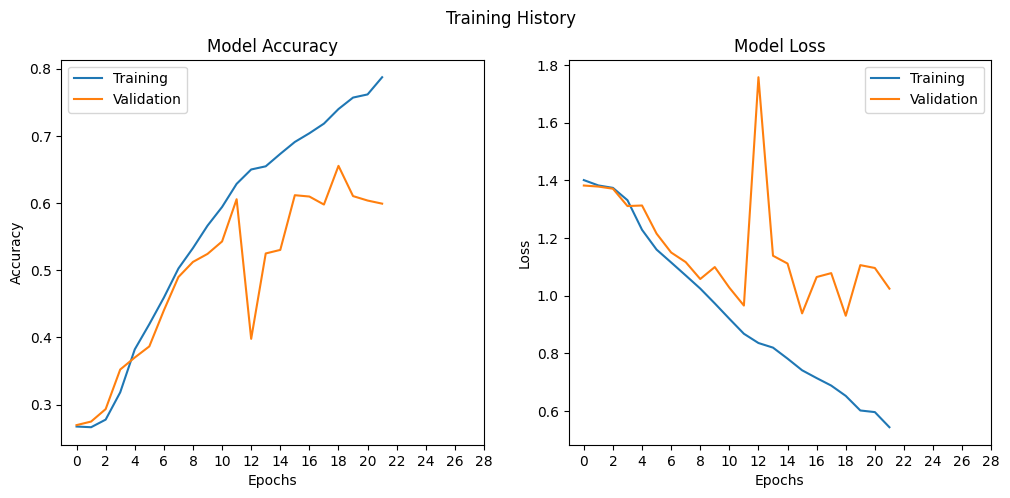

Accuracy of Fold 5: 65.10%


Restoring model weights from the end of the best epoch: 9.
Epoch 19: early stopping


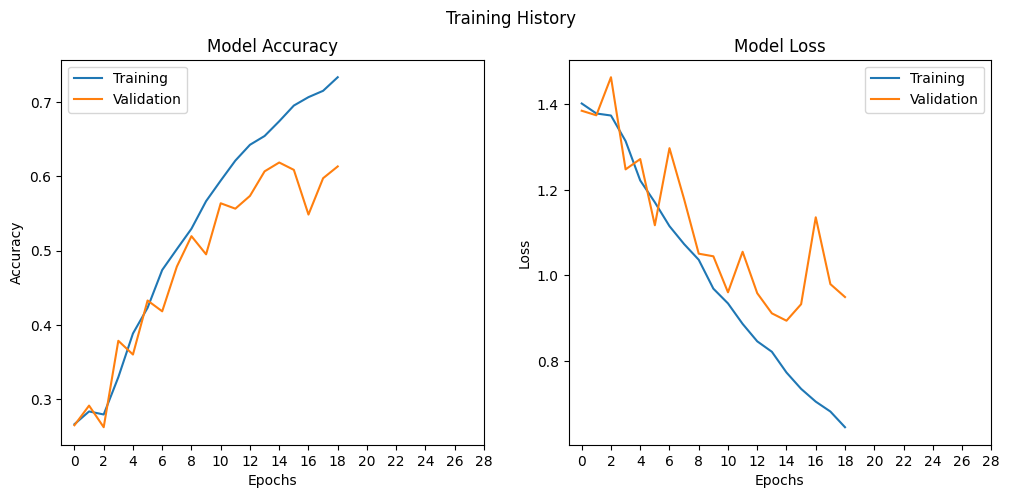

Accuracy of Fold 6: 56.62%


Restoring model weights from the end of the best epoch: 12.
Epoch 22: early stopping


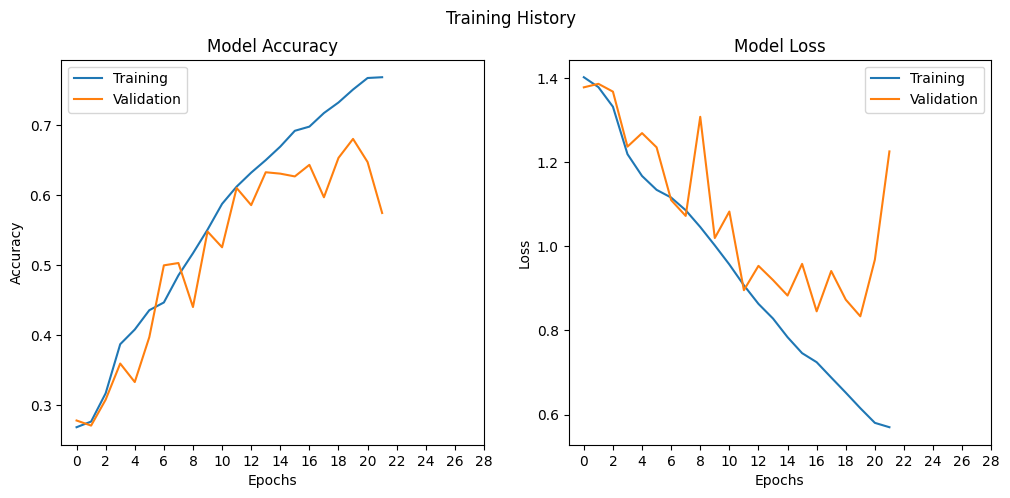

Accuracy of Fold 7: 64.94%


Restoring model weights from the end of the best epoch: 8.
Epoch 18: early stopping


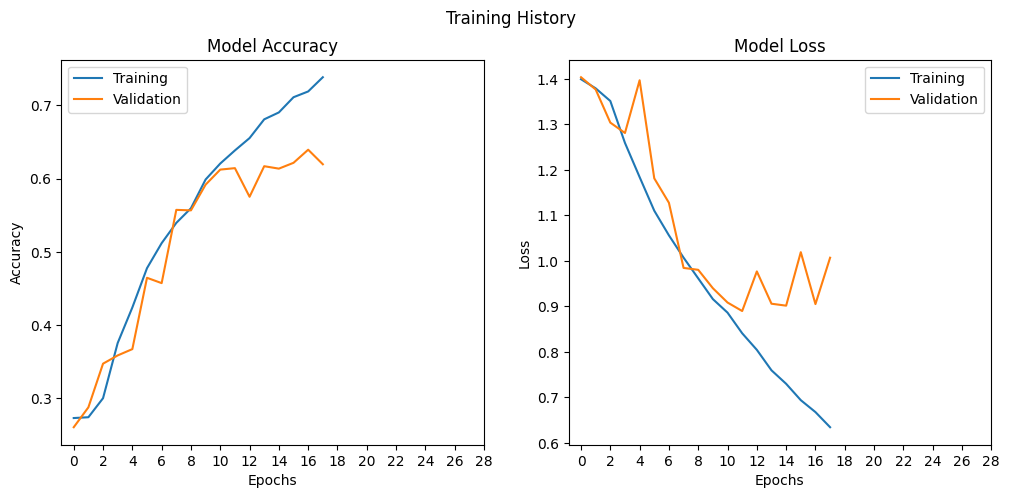

Accuracy of Fold 8: 57.12%


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


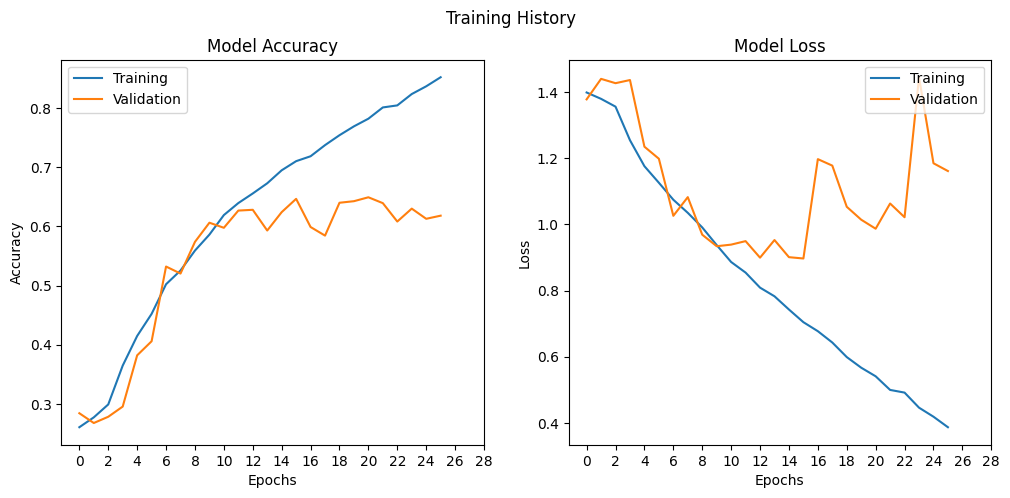

Accuracy of Fold 9: 67.75%


Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping


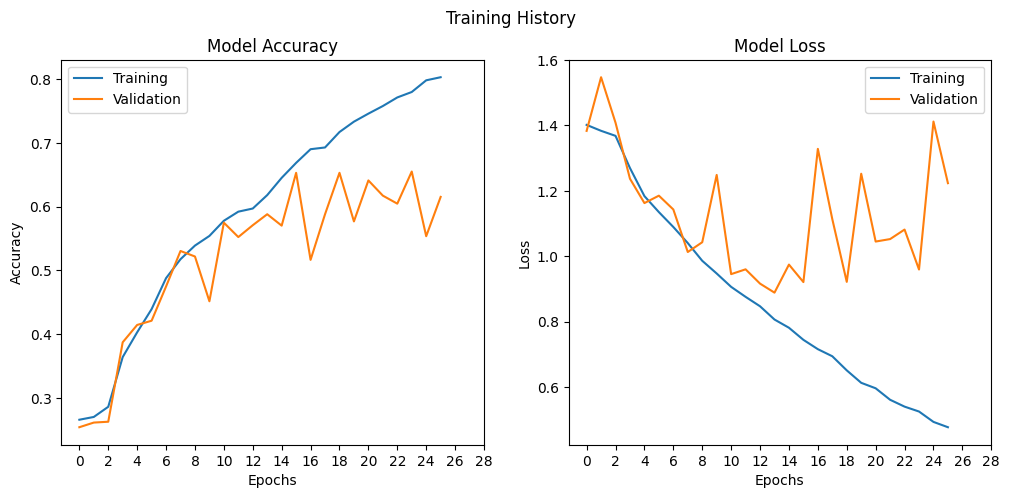

Accuracy of Fold 10: 66.49%




**********************************************************************
[0.6288928985595703, 0.6831424832344055, 0.6421539187431335, 0.5866988301277161, 0.650994598865509, 0.5662045478820801, 0.6493871808052063, 0.5712276697158813, 0.6775165796279907, 0.664858341217041]
----------------------------------------------------------------------
Average Loss: 0.91
Average Accuracy: 63.21%


In [ ]:
cross_validate(create_model_4)

🔎 **Observations:** Even though we have almost the same accuracy score, this time, we couldn't regularize the model as we were supposed to. If you check the gap between the training and validation accuracy scores on training plots, you'll notice that it's more than the previous model histories, especially towards the end of the training.

# Conclusion

As you may see we have tried 5 different model so far and we couldn't get the performance score we want. The models definitely perform better than a wild-guess however this is not what we aimed for.

You can also notice that there are a lot of hyperparameters to be tweaked to get better results which causes a lot of time try them all. That's why we need an approach which is smarter. That's why we'll first apply pre-trained models such as VGG16 in the upcoming section.

---

# Bibliography

[1]	Mehrabian, A. (2008). Communication without words. Communication theory, 6, 193-200.

[2]	Spezialetti, M., Placidi, G., & Rossi, S. (2020). Emotion recognition for human-robot interaction: Recent advances and future perspectives. Frontiers in Robotics and AI, 145.

[3]	Li, S., & Deng, W. (2020). Deep facial expression recognition: A survey. IEEE transactions on affective computing, 13(3), 1195-1215.

[4]	Dsouza, J. (2020, April). “What is a GPU and do you need one in Deep Learning?”: Towards Data Science. https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d